To install Unity mlagent library follow the instruction provided in their documentaion

https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md

In [1]:
# To test if the library instalation successfull run the following
from mlagents.envs import UnityEnvironment
# If no error occors instalation is success 

Download the game from following link
https://drive.google.com/drive/u/0/folders/155Z71QdXSCa7XRmnzXggb1ZwJl-A6iZd

<b> Windows users : </b> windows_build 

<b> Linux users   : </b> linux_build

In [2]:
# symbolic representation 

In [3]:
from enum import Enum

"""
Constants used for creating symbolic representation
"""


class Constant:
    STATE_HEIGHT = 14
    STATE_WIDTH = 17
    STATE_WIDTH_BOUND = STATE_WIDTH - 1
    SCALE_X = 25
    SCALE_Y = 30


class StateKey(Enum):
    EMPTY = 1
    FROG = 2
    RED_CAR = 3
    LOG = 4
    PLATFORM = 5
    WIN = 6
    HAZARD_ZONE = 7
    START = 8
    WALL = 9
    TUNNEL_ON_KEY = 10
    BLUE_CAR = 11

In [4]:
# symbolic creation
def create_sym_rep(observation_data):
    # frog in goal and witch ine is it ?
    frog_in_goal = int(observation_data[33])  # 0- if none , 1 - for right most one and 2 for left one
    # is car in tunnel
    car_in_tunnel = int(observation_data[32])  # 1 if car is inside the tunnel
    # frog position send them as the index for the state array
    # (12,8) will be the start position
    # to calculate x position (original x value - 50) / 25 and round this to nearest int (coz of the logs)
    # y should be fixed and when it go up or down +1 or - 1
    frog_x = int(observation_data[0])
    frog_y = int(observation_data[1])

    current_state = [[0] * Constant.STATE_WIDTH for i in range(Constant.STATE_HEIGHT)]

    # reset state part

    # init all to empty
    # only need to do this from 5 - 11 index (road part)

    for i in range(5, 12):
        for j in range(0, Constant.STATE_WIDTH):
            current_state[i][j] = StateKey.EMPTY.value

    # add platform and start pos
    # 13 - start , 12,4 platform
    for j in range(0, Constant.STATE_WIDTH):
        current_state[13][j] = StateKey.START.value
        current_state[12][j] = StateKey.PLATFORM.value
        current_state[4][j] = StateKey.PLATFORM.value

    # fill with hazard zone
    # rows 0 - 3 and col - all
    for i in range(0, 4):
        for j in range(0, Constant.STATE_WIDTH):
            current_state[i][j] = StateKey.HAZARD_ZONE.value

    # add goal positions
    # if frog is in the goal mark it as hazard ???
    # goal pos 1 is in 5 - 6 col in 0 th row
    for j in range(5, 7):
        # frog is in 1st goal pos
        if frog_in_goal == 1:
            current_state[0][j] = StateKey.HAZARD_ZONE.value
        else:
            current_state[0][j] = StateKey.WIN.value

    # goal pos 2 is in 10 - 11 col in 0 th row
    for j in range(10, 12):
        # frog is in 2nd goal pos
        if frog_in_goal == 2:
            current_state[0][j] = StateKey.HAZARD_ZONE.value
        else:
            current_state[0][j] = StateKey.WIN.value

    # mark tunnel
    # if car in tunnel mark it as lit  ow as a wall
    # its in row 8 col [6-12]
    for j in range(6, 13):
        # frog is in 2nd goal pos
        if car_in_tunnel == 1:
            current_state[8][j] = StateKey.TUNNEL_ON_KEY.value
        else:
            current_state[8][j] = StateKey.WALL.value

    # frog position
    # from game I can directly send frog x , y as a index for this array
    current_state[frog_y][frog_x] = StateKey.FROG.value

    # Add cars / logs
    # array  observations [2 - 20]
    # s , x , z

    index = 1  # easy to travel the array 1st car y data at 4 th index
    for i in range(0, 10):
        index += 3
        x_pos = int(observation_data[index - 1])
        y_pos = int(observation_data[index])
        size = int(observation_data[index - 2])

        # out of view car /log
        if x_pos + size <= 0 or x_pos > 16:
            continue
        elif x_pos < 0 < x_pos + size:
            size = size + x_pos
            x_pos = 0
        # car in tunnel lane
        if y_pos == 8:
            # car is fully in tunnel
            if x_pos >= 6 and x_pos + size <= 12:
                continue
            # car is left and in tunnel
            elif x_pos < 6 <= x_pos + size:
                for j in range(x_pos, 6):
                    current_state[y_pos][j] = StateKey.RED_CAR.value
            elif x_pos <= 12 < x_pos + size:
                for j in range(13, x_pos + size):
                    current_state[y_pos][j] = StateKey.RED_CAR.value
            # out of tunnel
            else:
                for j in range(x_pos, x_pos + size):
                    if j > 16:
                        break
                    current_state[y_pos][j] = StateKey.RED_CAR.value

        # all other cars /logs
        elif index <= 32:
            # todo : get car color from game
            # for blue cars
            if y_pos == 5 or y_pos == 7 or y_pos == 9 or y_pos == 10:
                for j in range(x_pos, x_pos + size):
                    if j > 16:
                        break
                    current_state[y_pos][j] = StateKey.BLUE_CAR.value
            # for red cars
            elif y_pos == 6 or y_pos == 8 or y_pos == 11:
                for j in range(x_pos, x_pos + size):
                    if j > 16:
                        break
                    current_state[y_pos][j] = StateKey.RED_CAR.value
            # logs
            else:
                for j in range(x_pos, x_pos + size):
                    if j > 16:
                        break
                    current_state[y_pos][j] = StateKey.LOG.value

    return  current_state

In [5]:
# Game access class 
# Can be found in : https://github.com/CORGI-lab/DQNFrogger/blob/master/GameHandler.py

In [6]:
import skimage
from mlagents.envs import UnityEnvironment
import numpy as np


# -- game handling class -- #
class Game:

    """
    set up unity ml agent environment
    @:param game_location  : file path for executable
    """
    def __init__(self, game_location):
        self.ENV_LOCATION = game_location
        self.load_env(0)

    """
    load unity environment
    @:param wid  : id for the worker in unity environment 
    """
    def load_env(self, wid):
        # load env
        env_name = self.ENV_LOCATION
        self.env = UnityEnvironment(env_name, worker_id=wid)
        # Set the default brain to work with
        self.default_brain = self.env.brain_names[0]
        self.brain = self.env.brains[self.default_brain]
        # Reset the environment - train mode enabled
        env_info = self.env.reset(train_mode=True)[self.default_brain]

    # this frogger game action space is 5, actions[0] = selected action (action = [[1]])
    # actions
    # 1 - up, 2 - down , 3- left , 4 -right , 0 - do nothing
    """
    performs a given action to the unity game 
    @:param action_value : action to be execute
    @:param image_height : Desire image height 
    @:param image_width  : Desire image width 
    @:param number_of_frames : stack size (this number of frames will e stack together by performing no op action )
    @:return reward : reward for the action 
    @:return stack  : stack of frames
    @:return terminal : if game reached terminal state or not
    @:return observation_data : return data that need for sym reps
    """
    def perform_action(self, action_value, image_height, image_width, number_of_frames=4):
        action = [[0]]
        action[0] = action_value
        terminal = False  # indication of terminal state
        # 3 - R, G, B
        size = (image_height, image_width, 3, number_of_frames)  # create list to keep frames
        stack = np.zeros(size)
        # to store data to sym rep 32 data is send from game
        observation_data = [[0] * 34 for i in range(number_of_frames)]

        # first frame after action
        env_info = self.env.step(action)[self.default_brain]  # send action to brain
        reward = round(env_info.rewards[0], 5)  # get reward
        new_state = env_info.visual_observations[0][0]  # get state visual observation
        observations = env_info.vector_observations  # get vector observations
        observation_data[0] = observations[0]
        # new_state_gray = skimage.color.rgb2gray(new_state)  # covert to gray scale
        new_state_gray = skimage.transform.resize(new_state, (image_height, image_width))  # resize
        # check terminal reached
        if env_info.local_done[0]:
            terminal = True

        # add the state to the 0 th position of stack
        stack[:, :, :, 0] = new_state_gray

        # get stack of frames after the action
        for i in range(1, number_of_frames):
            env_info = self.env.step()[self.default_brain]  # change environment to next step without action
            st = env_info.visual_observations[0][0]
            observations = env_info.vector_observations  # get vector observations
            observation_data[i] = observations[0]
            #st_gray = skimage.color.rgb2gray(st)
            st_gray = skimage.transform.resize(st, (image_height, image_width))
            stack[:, :, :, i] = st_gray
            # if terminal only consider the reward for terminal
            if env_info.local_done[0]:
                terminal = True
                reward = round(env_info.rewards[0], 5)

        # reshape for Keras
        # noinspection PyArgumentList
        stack = stack.reshape(1, stack.shape[0], stack.shape[1], stack.shape[2], stack.shape[3])

        return reward, stack, terminal, observation_data

    """
    close environment
    """
    def close(self):
        self.env.close()

    """
    Reset environment 
    """
    def reset(self):
        self.close()
        self.load_env(0)

In [7]:
# Create new unity game environment

# provide game location / game executable file name shoud be givn without the file extention 
game_loation  = "windows_build/UnityFrogger"
new_game = Game(game_loation)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: frogLearn
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 34
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [5]
        Vector Action descriptions: 
Unity brain name: frogplay
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [1]
        Vector Action descriptions: 


In [8]:
# send action to game 
# Valid actions for this game : 
#     0 - no operation 
#     1 - move up
#     2 - move down
#     3 - move left
#     4 - move right

action = 0# action to be send to the game 

# image size that you need to get as out put 
image_height  = 500 
image_width   = 500 

# send action to game 
# Output provide by this method are: 
#   reward   :  reward value for the action
#   stack    :  stack of 4 frames with the array of size  (1, image_height, image_width, 4)
#   terminal :  if the new state reached a terminal or not (true : terminal, false : non-terminal)
#   obervation_data : data to create sym rep
reward,stack,terminal,observation_data = new_game.perform_action(action, image_height, image_width)

In [9]:
print("Action              :", action)
print("Reward              :", reward)
print("Is terminal reached :", terminal)

Action              : 0
Reward              : 0.0
Is terminal reached : False


In [10]:
# create sym rep for the last frame
symbolic = create_sym_rep(observation_data[3])

In [11]:
# Access frames 
import matplotlib.pyplot as plt

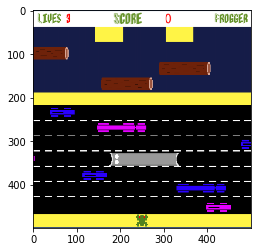

In [12]:
# This will provide the 1 st frame in the frame stack
plt.imshow(stack[0][:,:,:,0]) # to access other frames change last 0 in the stack list to desire frame number 

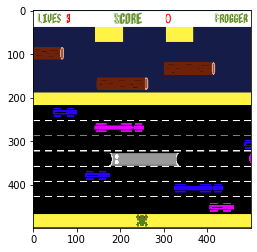

In [13]:
# last frame 
plt.imshow(stack[0][:,:,:,3])

In [14]:
# symbolic representation for the last frame
symbolic

[[7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7],
 [4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 7, 7, 7],
 [7, 7, 7, 7, 7, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [1, 11, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1],
 [1, 1, 1, 1, 11, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 11, 11, 11, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1],
 [5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]

In [15]:
# close unity game
new_game.close()